# Some fancy Title

## Goal of the project

-) Is there any connection between the location of an AirBnb and Points of interests around it, to the location rating
-) How well can a new location of an AirBnb be predicted

## Data sets

### listings.csv

Source: http://data.insideairbnb.com/austria/vienna/vienna/2022-09-11/data/listings.csv.gz

This data set contains information about listed AirBnb apartments/rooms in Vienna on the 12th of October 2022. This data set was chosen as it contains location data as well as review ratings for each listed apartment/room.

TODO: Describe data set in more detail

### LANDESGRENZEOGD.csv

Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:LANDESGRENZEOGD&srsName=EPSG:4326&outputFormat=csv

This data set contains geolocation data about the borders of the Austrian federal states. This data set was chosen, to get the exact borders of Vienna. This was especially useful for plotting.

### HALTESTELLEWLOGD.csv
Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:HALTESTELLEWLOGD&srsName=EPSG:4326&outputFormat=csv

This data set contains information about each of the public transport stations. This data set was chosen, as the geolocation of each transport station is contained in it.

### WIENTOURISMUSOGD.csv
Source: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&srsName=EPSG:4326&outputFormat=csv&typeName=ogdwien:WIENTOURISMUSOGD

This data set contains information about points of interests for tourists. This data set was chosen, as it is offers a wide variety of different types of locations tourists might be interested in.

TODO: Describe data set in more detail

### district_to_post.csv

Source: Handmade by authors of this project

This data set is basically just a mapping file, which provides a conversion between the postal code and the name of viennese district. This data set was created to join the listings.csv with the other data sets.

### rent_buy.csv
Source: https://www.immopreise.at/Wien/Wohnung/Miete
Handscrapped on 16/12/2022

This data set contains information about the average rent per square metre and average price per square metre of appartements in Vienna. This data set was chosen to provide information about expenses of an AirBnb appartement.

### model_data.csv

Source: Created by this Jupyternotebook

This data set was created out of the ones above and provides the data for the further analysis.

## Imports
The following libraries are used in this project. We also turned of the chained_assignment mode as this would cause problems, we avoid by reassigning the data sets instead of copying.

In [153]:
import pandas as pd
import geopy.distance
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.prepared import prep
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.api import OLS
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
pd.options.mode.chained_assignment = None

## Data cleaning

First we load the data set, then we remove the columns we do not need for our analysis. As shown below, the data set contains multiple columns containing information about the host, this is not needed for either of the target questions. Also, the information about the source, when it was scrapped or the url of the listings are dropped. The name and the description of the individual listing are not needed either, as this tasks focus mainly on price and location. Therefore, we only keep the columns that are related to price (`price` and `accommodates` as these will be needed to calculate the price per person) or to the location (`neighbourhood_cleansed` and the geolocation). The other columns that are kept either contain critical information to identify the listing (`ìd`) or provide additional information that might influence the price or the review of a location, without it being dependent on the host.

In [116]:
listings = pd.read_csv("data/listings.csv")
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [117]:
listings_cleaned = listings[["id", "neighbourhood_cleansed", "latitude", "longitude", "property_type",
                             "room_type", "accommodates", "price","number_of_reviews",
                             "review_scores_rating", "review_scores_location", "reviews_per_month"]]

In a next step we clean the `price` column of the $ sign, so we can later on cast it to numeric. Furthermore, we assign the correct data types to the columns.

In [118]:
listings_cleaned['price'] = listings_cleaned['price'].str.extract('(\d+)', expand=False)
listings_cleaned[['price']] = listings_cleaned[['price']].apply(pd.to_numeric)
listings_cleaned.astype({
    "id" : int, "neighbourhood_cleansed": 'category', "latitude": float, "longitude": float, "property_type": 'category',
                             "room_type": 'category', "accommodates": int, "number_of_reviews": int,
                             "review_scores_rating": float, "review_scores_location": float, "reviews_per_month": float
})
listings_cleaned.dtypes

id                          int64
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
price                       int64
number_of_reviews           int64
review_scores_rating      float64
review_scores_location    float64
reviews_per_month         float64
dtype: object

Now we can identify all missing values

In [119]:
listings_cleaned.isna().sum()

id                           0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
price                        0
number_of_reviews            0
review_scores_rating      1928
review_scores_location    2024
reviews_per_month         1928
dtype: int64

The number of missing values in columns `review_scores_rating` and `reviews_per_month` suggest, that there is no rating, if there are no reviews, so we check if they are missing always in the same observations, having no reviews.

In [120]:
all(listings_cleaned['review_scores_rating'].isna() == listings_cleaned["reviews_per_month"].isna())

True

In [121]:
all(listings_cleaned['review_scores_rating'].isna() == (listings_cleaned['number_of_reviews'] == 0))

True

As we can see our assumptions is true, if we have no reviews we have a missing value, therefore the data for the two columns are missing at random. Now we first visualize the missing data on a grid, to see if there is some pattern. To do so we first need the `LANDESGRENZEOGD.csv` for the borders of Vienna. We read in the data set and create a Polygon object.

In [122]:
vienna_border = pd.read_csv("data/LANDESGRENZEOGD.csv")

def create_polygon(x):
    x['Polygon'] = shapely.wkt.loads(x['SHAPE'])
    return x

vienna_border = vienna_border.apply(lambda x: create_polygon(x), axis=1)
vienna_border.drop("SHAPE", inplace=True, axis=1)
vienna_border.head()

,FID,OBJECTID,NAME_LANDK,NAME_LANDG,NAME_GEMK,NAME_GEMG,STATAUSTRIA_LAND_KENN,STATAUSTRIA_GEM_KENN,STATAUSTRIA_BEZ_KENN,STATAUSTRIA_BEZ_CODE,FLAECHE,UMFANG,LU_DATE,SE_ANNO_CAD_DATA,Polygon
0,LANDESGRENZEOGD.10881,10881,Wien,WIEN,Stadt Wien,STADT WIEN,9,90001,900,900,4.148711e+08,136475.45,2022-08-26,NaN,POLYGON ((16.437761721115034 48.31681098205513...


As a next step we generate a grid to cover whole of Vienna, so we can more clearly see proximity of data points. This code chunk was heavily inspired by https://www.matecdev.com/posts/shapely-polygon-gridding.html.

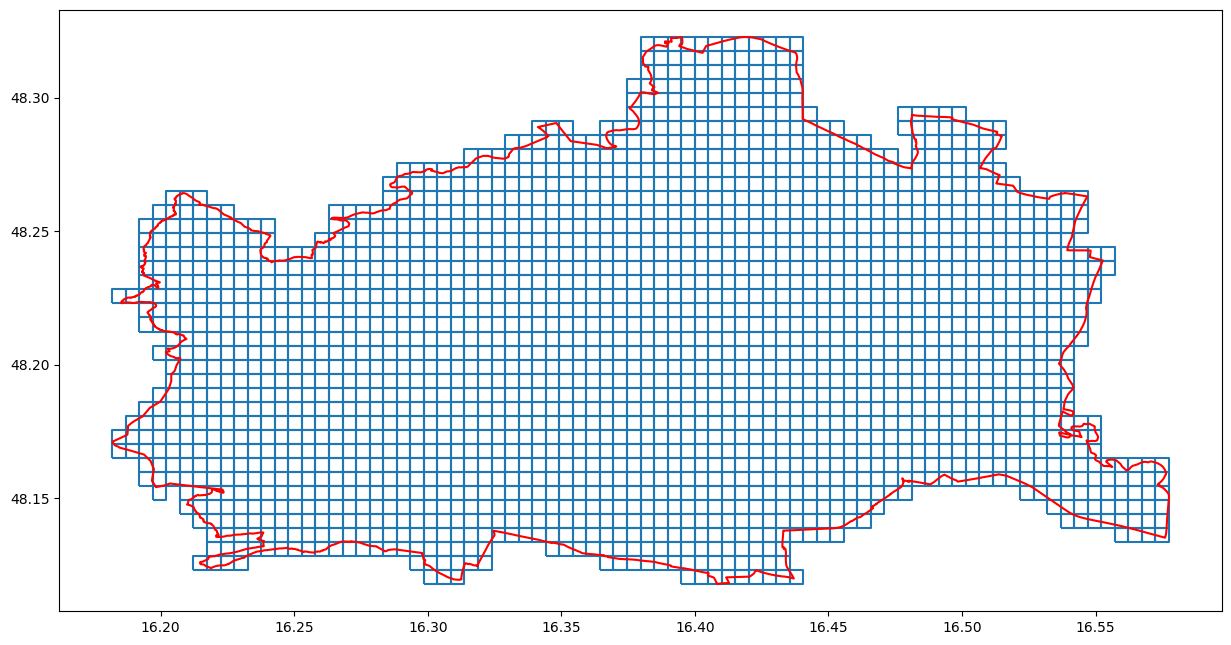

In [123]:
def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx) / delta)
    ny = int((maxy - miny) / delta)
    gx, gy = np.linspace(minx, maxx, nx), np.linspace(miny, maxy, ny)
    grid = []
    for i in range(len(gx) - 1):
        for j in range(len(gy) - 1):
            poly_ij = Polygon([[gx[i], gy[j]], [gx[i], gy[j + 1]], [gx[i + 1], gy[j + 1]], [gx[i + 1], gy[j]]])
            grid.append(poly_ij)
    return grid


def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid


geom = vienna_border.Polygon[0]
grid = partition(geom, 0.005)

fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
plt.show()

The plot is skewed a little bit, as the grid is defined by geolocation coordinates and the plot ignores the curvature of earth completely. This however does not change the fact, that each grid cell has same amount of square metres.

As a next step, we create a Point object out of the geolocation for each listing. Then we assign each listing the id of the grid cell it lies in. As this takes quite some time to calculate, we save the result in a new file, `grid_listings.csv`, and in a new data frame.

In [124]:
def create_point(x, from_shape=True, column1=None, column2=None):
    if from_shape:
        x['Point'] = shapely.wkt.loads(x['SHAPE'])
    else:
        x['Point'] = Point(x[column1], x[column2])
    return x

listings_cleaned = listings_cleaned.apply(
    lambda x: create_point(x, from_shape=False, column1='longitude', column2='latitude'), axis=1)

def inside_square(x, grid):
    point = x['Point']
    for sq_id, square in enumerate(grid):
        if square.contains(point):
            x['grid_id'] = sq_id
    return x


grid_listings = listings_cleaned.apply(lambda x: inside_square(x, grid), axis=1)

In [125]:
grid_listings.to_csv("data/grid_listings.csv")
grid_listings.head()

,Point,accommodates,grid_id,id,latitude,longitude,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type
0,POINT (16.42767 48.24262),3,1364.0,15883,48.24262,16.42767,Donaustadt,14,110,Room in bed and breakfast,4.71,4.71,0.15,Hotel room
1,POINT (16.37831 48.21924),5,976.0,38768,48.21924,16.37831,Leopoldstadt,350,69,Entire rental unit,4.75,4.75,2.50,Entire home/apt
2,POINT (16.32701 48.18434),6,665.0,40625,48.18434,16.32701,Rudolfsheim-Fnfhaus,181,145,Entire rental unit,4.59,4.83,1.23,Entire home/apt
3,POINT (16.37161 48.21496),2,943.0,392757,48.21496,16.37161,Innere Stadt,100,100,Entire rental unit,4.89,4.64,0.79,Entire home/apt
4,POINT (16.37847 48.21778),3,976.0,51287,48.21778,16.37847,Leopoldstadt,347,68,Entire rental unit,4.86,4.65,2.45,Entire home/apt


Now we have all the information we need to plot the listings on the map and marking the grid cells containing listings with missing values. To do so we first get all empty grid cells and the grid cells containing missing values, so we can plot them differently:

In [126]:
empty_sq = []
missing_review_sq = []
missing_loc_review_sq = []
grid_id_list = list(grid_listings['grid_id'])
grid_missing_review_id_list = list(grid_listings[grid_listings['number_of_reviews'] == 0]['grid_id'])
grid_missing_loc_review_id_list = list(grid_listings[grid_listings['review_scores_location'].isna()]['grid_id'])
for idx, sq in enumerate(grid):
    if idx not in grid_id_list:
        empty_sq.append(sq)
    if idx in grid_missing_review_id_list:
        missing_review_sq.append(sq)
    if idx in grid_missing_loc_review_id_list:
        missing_loc_review_sq.append(sq)

In the next code chunk we use that to plot the above selected cells on the map.

In [127]:
legend_elements = [Patch(facecolor='white', edgecolor='b',
                         label='No Listing'),
                   Patch(facecolor='darkgreen', edgecolor='b',
                         label='Listing without NA'),
                   Patch(facecolor='black', edgecolor='b',
                         label='Listing with no reviews'),
                   Patch(facecolor='yellow', edgecolor='b',
                         label='Listing with NA in review_scores_location')]

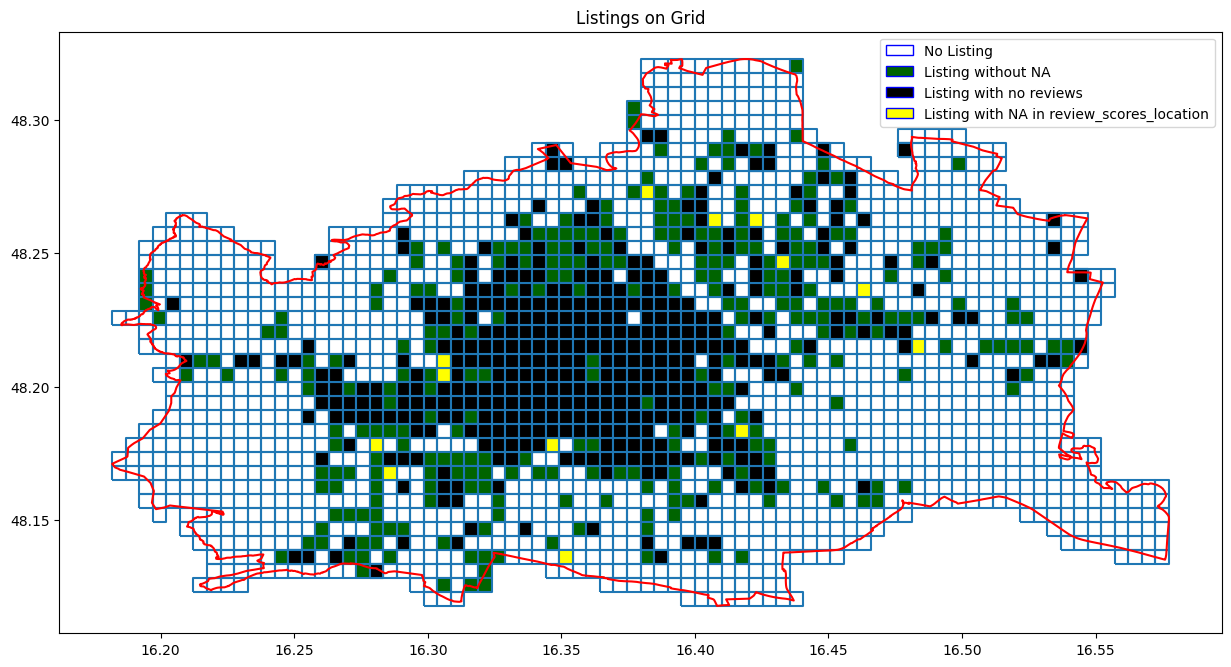

In [128]:
plot_grid = list(set(grid) - set(empty_sq))
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(empty_sq).boundary.plot(ax=ax)
gpd.GeoSeries(plot_grid).boundary.plot(ax=ax, facecolor="darkgreen")
gpd.GeoSeries(missing_loc_review_sq).boundary.plot(ax=ax, facecolor="yellow")
gpd.GeoSeries(missing_review_sq).boundary.plot(ax=ax, facecolor="black")
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
ax.legend(handles=legend_elements)
plt.title("Listings on Grid")
plt.show()

This map shows that there is no real pattern for listings not having any reviews. But it seems like most of the `review_scores_location` missing values are due to the number of reviews being zero. So we check this assumption:


In [129]:
len(grid_listings[(grid_listings['number_of_reviews']!=0) & (grid_listings['review_scores_location'].isna())])

96

As we can see only 96 observations have missing values, if there are reviews available. We assume that these are MAR as well, as some people did not rate the location, but left an overall review score. Therefore, as dropping the observations would lose us about a fifth of the available listings and we suspect the data is MAR, we use MICE instead to impute the missing values.

In [130]:
df_mice = grid_listings.filter(['accommodates', 'grid_id', 'id',  'number_of_reviews',
                                'price',  'review_scores_location', 'review_scores_rating','reviews_per_month'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
grid_listings[['review_scores_location', 'review_scores_rating', 'reviews_per_month']] = df_mice_imputed[['review_scores_location', 'review_scores_rating', 'reviews_per_month']]

In [131]:
grid_listings.isna().sum()

Point                      0
accommodates               0
grid_id                   70
id                         0
latitude                   0
longitude                  0
neighbourhood_cleansed     0
number_of_reviews          0
price                      0
property_type              0
review_scores_location     0
review_scores_rating       0
reviews_per_month          0
room_type                  0
dtype: int64

Above we can see that we have 70 listings that have no `grid_id`, first we check if those are actually the ones outside of Vienna, we do that by plotting again.

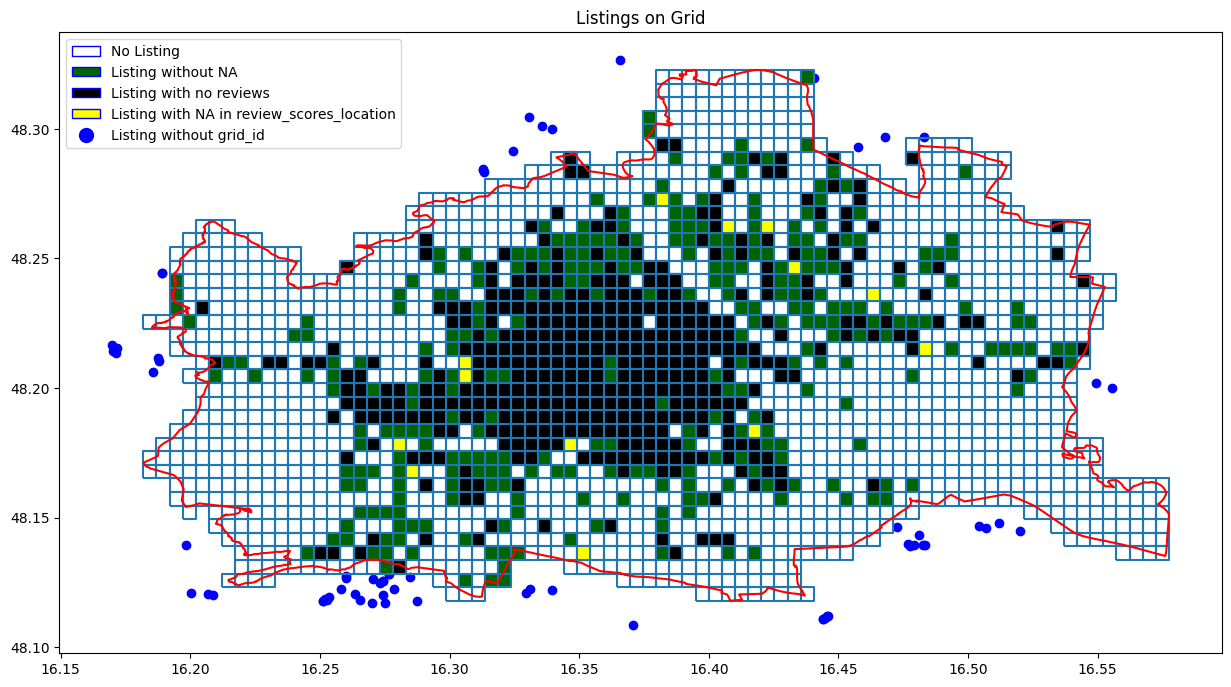

In [159]:
legend_elements = [Patch(facecolor='white', edgecolor='b',
                         label='No Listing'),
                   Patch(facecolor='darkgreen', edgecolor='b',
                         label='Listing without NA'),
                   Patch(facecolor='black', edgecolor='b',
                         label='Listing with no reviews'),
                   Patch(facecolor='yellow', edgecolor='b',
                         label='Listing with NA in review_scores_location'),
                   Line2D([0], [0], marker='o', color='blue', label='Listing without grid_id',
                      markerfacecolor='blue', markersize=10, ls = '')]
possibly_outside = grid_listings.copy()
possibly_outside.isna().sum()
possibly_outside_points = possibly_outside[possibly_outside['grid_id'].isna()]
plot_grid = list(set(grid) - set(empty_sq))
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(empty_sq).boundary.plot(ax=ax)
gpd.GeoSeries(plot_grid).boundary.plot(ax=ax, facecolor="darkgreen")
gpd.GeoSeries(missing_loc_review_sq).boundary.plot(ax=ax, facecolor="yellow")
gpd.GeoSeries(missing_review_sq).boundary.plot(ax=ax, facecolor="black")
gpd.GeoSeries(possibly_outside_points['Point']).plot(ax=ax, color="blue")
gpd.GeoSeries([geom]).boundary.plot(ax=ax, color="red")
ax.legend(handles=legend_elements)
plt.title("Listings on Grid")
plt.show()

It is clearly visible, that all those listings are outside of Vienna, as the scope of the project is defined by looking at listings in Vienna, we remove those from the `grid_listings`

In [160]:
grid_listings=grid_listings.dropna()
grid_listings.isna().sum()

Point                     0
accommodates              0
grid_id                   0
id                        0
latitude                  0
longitude                 0
neighbourhood_cleansed    0
number_of_reviews         0
price                     0
property_type             0
review_scores_location    0
review_scores_rating      0
reviews_per_month         0
room_type                 0
dtype: int64

Now we have cleaned the `grid_listings`. As the price is not really comparable due to different sizes of appartements/rooms, we try to make it more comparable by introducing a new column: `price_per_person`. This way appartements/rooms for more than one person do not have a significantly higher price per default than single person appartements/rooms.

In [161]:
grid_listings['price_per_person'] = grid_listings['price']/grid_listings['accommodates']
grid_listings.to_csv("data/grid_listings_cleaned.csv")

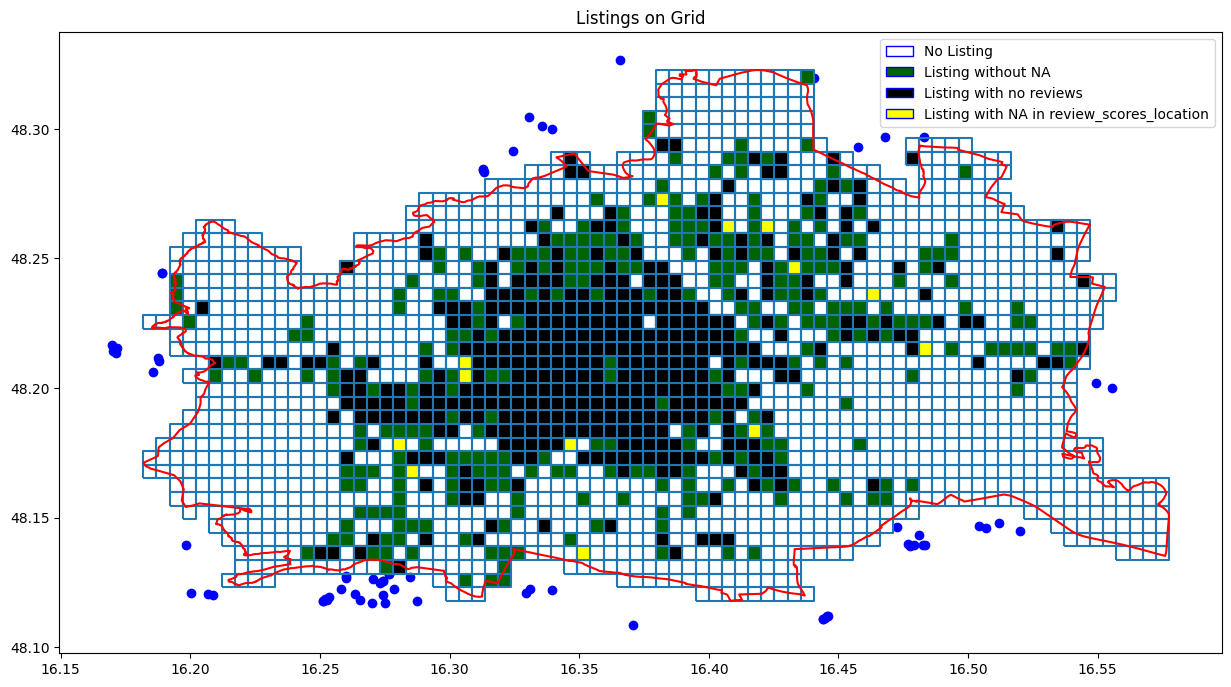

0     POINT (16.31303 48.28441)
1     POINT (16.26007 48.12762)
2     POINT (16.47677 48.13977)
3     POINT (16.27668 48.12814)
4     POINT (16.46811 48.29685)
                ...            
65    POINT (16.27051 48.12623)
66    POINT (16.48121 48.14341)
67    POINT (16.48278 48.13932)
68    POINT (16.27426 48.11997)
69    POINT (16.17128 48.21360)
Length: 70, dtype: geometry